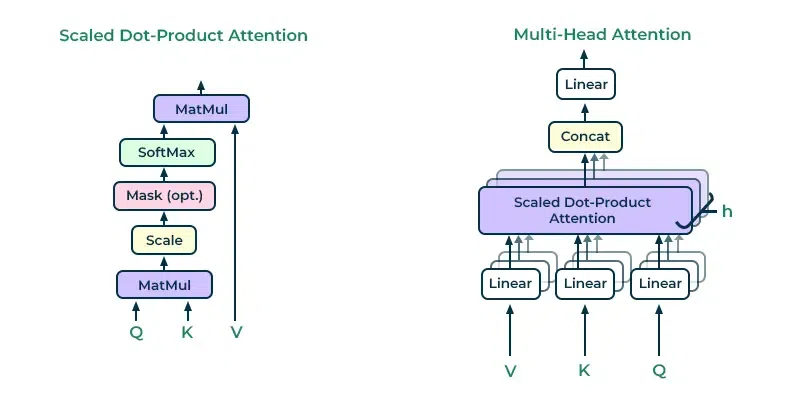

#**Self Attention / Scaled dot product Attention Implementation from Scratch**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class SelfAttention(nn.Module):
  # d_in input dimention
  # d_out output dimension
  def __init__(self, d_in, d_out):
    super().__init__()
    self.d_in = d_in
    self.d_out = d_out
    self.Q = nn.Linear(d_in, d_out) #input dimention is encoded sentence.
    self.K = nn.Linear(d_in, d_out)
    self.V = nn.Linear(d_in, d_out)
  def forward(self,x):  #x.shape = (batch_size, seq_length, input_dim) Here x is the encoded output of the input text
    queries = self.Q(x)
    keys = self.K(x)
    values = self.V(x)
    scores = torch.bmm(queries, keys.transpose(1,2)) # perform batch matrix  multiplications
    scores = scores / (self.d_out ** 0.5)
    attention = F.softmax(scores, dim = 2)
    hidden_states = torch.bmm(attention, values)
    return hidden_states


In [1]:
SOS_token = 0
EOS_token = 1
index2words = {
    SOS_token: 'SOS',
    EOS_token: 'EOS'
}
words = "Hello World ! What programming language are you learning ?"
words_list = set(words.lower().split(' '))
for word in words_list:
  index2words[len(index2words)] = word
index2words

{0: 'SOS',
 1: 'EOS',
 2: '?',
 3: 'are',
 4: 'programming',
 5: 'learning',
 6: 'hello',
 7: 'you',
 8: '!',
 9: 'language',
 10: 'what',
 11: 'world'}

In [2]:
words2index = {w:i for i, w in index2words.items()}
words2index


{'SOS': 0,
 'EOS': 1,
 '?': 2,
 'are': 3,
 'programming': 4,
 'learning': 5,
 'hello': 6,
 'you': 7,
 '!': 8,
 'language': 9,
 'what': 10,
 'world': 11}

In [5]:
def convert2tensors(sentence):
  words_list = sentence.lower().split(' ')
  indexes = [words2index[word] for word in words_list]
  return torch.tensor(indexes, dtype = torch.long).view(1,-1) #returing tensor object with dimention [1,*]
sentence = "Hello World !"
convert2tensors(sentence)

tensor([[ 6, 11,  8]])

In [ ]:
hidden_size = 10
vocab_size = len(words2index)
embedding = nn.Embedding(vocab_size, hidden_size) #embedded the each word into 10 dim embedding
attention = SelfAttention(hidden_size,hidden_size)
sentence = "Hello World !"
input_tensor = convert2tensors(sentence)
embedded = embedding(input_tensor)
embedded.size()


torch.Size([1, 3, 10])

In [ ]:
embedded

tensor([[[ 0.2213,  0.1702,  1.0206,  1.3710, -1.2454, -0.2870, -1.0051,
          -1.5598, -0.8062,  1.1408],
         [-1.5857,  0.0806,  0.7509,  0.1588, -0.2736,  0.3742,  1.0324,
           0.3751, -0.3552, -0.4065],
         [ 0.2205,  0.2434, -0.2039,  1.4058,  1.1142,  0.3092, -2.1270,
           1.5012,  0.8489,  0.6300]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
hidden_states = attention.forward(embedded)

In [ ]:
hidden_states.size()

torch.Size([1, 3, 10])

In [ ]:
hidden_states

tensor([[[ 0.2752, -0.2509,  0.1933, -0.3089,  0.0729,  0.1246,  0.4456,
           0.0331, -0.0647,  0.4276],
         [ 0.2917, -0.0650,  0.2577, -0.2054,  0.0747,  0.1583,  0.1935,
           0.1437,  0.0475,  0.2823],
         [ 0.2857, -0.1586,  0.2289, -0.2538,  0.0761,  0.1384,  0.3285,
           0.0862, -0.0044,  0.3495]]], grad_fn=<BmmBackward0>)

# **MultiHead Attention**

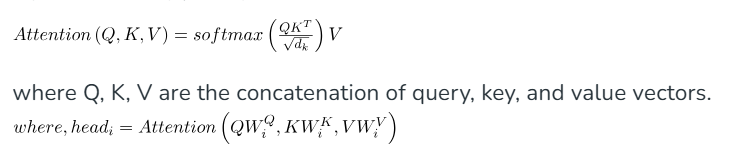

In [39]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, num_heads):
    super().__init__()
    self.d_in = d_in
    self.d_out = d_out
    self.num_heads = num_heads
    self.depth = d_out // self.num_heads ##dimention of each head's output

    self.W_Q = nn.Linear(d_in, d_out)
    self.W_K = nn.Linear(d_in, d_out)
    self.W_V = nn.Linear(d_in, d_out)
    self.concat = nn.Linear(d_out, d_out)


  def split_heads(self,x, batch_size):
    x = x.contiguous().view(batch_size, -1, self.num_heads, self.depth)
    return x.permute(0,2,1,3)   ##Rearranging the shape: (batch_size, nums_head, sequence_len, depth)

  def forward(self,x):
    batch_size = x.shape[0]
    queries = self.W_Q(x)
    keys = self.W_K(x)
    values = self.W_V(x)

    #Split the Q,K,V into multiple heads
    queries = self.split_heads(queries, batch_size)
    keys = self.split_heads(keys, batch_size)
    values = self.split_heads(keys, batch_size)

    # calculate attention score(scaled dot product)
    scores = torch.matmul(queries, keys.transpose(-2,-1)) # perform batch matrix  multiplications #transpose(-2,-1) swaps the last two dimensions of the tensor.
    scores = scores / (self.d_out ** 0.5)
    attention = F.softmax(scores, dim = 2)
    hidden_states = torch.matmul(attention, values)

    #concat heads
    output = hidden_states.permute(0,2,1,3).contiguous()
    output = output.view(batch_size, -1, self.d_out)

    #Apply final Linear Transformation
    output = self.concat(output)
    return output


In [40]:

seq_len = 5
d_in = 8
d_out = 12
num_heads = 3 ## d_out must be divisible by num_heads
mha = MultiHeadAttention(d_in, d_out, num_heads)
x = torch.randn(2, seq_len, d_in)
x

tensor([[[ 1.3031, -0.0128, -0.8168,  1.5133,  0.7393, -0.4509,  0.0066,
          -0.0471],
         [-0.2252, -0.2203, -0.5696,  0.4896,  0.1038,  0.6613, -0.5791,
           0.1678],
         [ 0.4161,  1.8533, -2.5233,  1.2840, -0.0077,  0.0139,  1.3530,
          -0.9121],
         [ 0.7090, -0.1687, -2.0506,  1.7829, -0.0063, -0.3323,  0.9252,
          -0.5291],
         [ 0.1922,  1.7901,  0.3032, -0.5651, -0.4867, -0.3868,  2.3922,
          -0.1852]],

        [[ 0.6035, -0.7997, -0.7698, -0.0598, -1.5005,  0.4249,  0.1235,
           0.0172],
         [ 1.4344,  1.1143, -0.2492,  1.1664,  0.4169,  0.3873, -0.5739,
           1.5744],
         [ 0.1385, -0.1935,  0.4547,  0.3321, -0.3125,  0.1051,  1.8449,
          -1.1287],
         [ 0.5742, -0.6848, -0.3264,  0.6550,  0.0828,  0.4746,  0.9972,
          -1.3421],
         [ 0.9279,  0.5540,  2.1335, -1.1949,  1.6403, -2.0241,  0.4721,
           2.0574]]])

In [41]:
output = mha(x)
print(output.shape)
output

torch.Size([2, 5, 12])


tensor([[[ 0.0935,  0.1753, -0.0391, -0.1369,  0.0075,  0.3184, -0.1999,
          -0.0453, -0.5247, -0.0271,  0.0995, -0.0775],
         [ 0.0916,  0.1681, -0.0603, -0.1153,  0.0350,  0.3295, -0.1879,
          -0.0545, -0.5202, -0.0195,  0.0953, -0.0755],
         [ 0.1136,  0.2200, -0.0477, -0.1334, -0.0043,  0.3319, -0.1899,
          -0.0570, -0.5437, -0.0457,  0.1060, -0.0371],
         [ 0.1255,  0.2275, -0.0382, -0.1522, -0.0115,  0.3417, -0.1952,
          -0.0598, -0.5732, -0.0326,  0.0951, -0.0218],
         [ 0.1019,  0.1661, -0.0634, -0.0813,  0.0582,  0.3334, -0.1997,
          -0.0164, -0.4874, -0.0423,  0.1249, -0.0944]],

        [[ 0.1762, -0.0614,  0.1542, -0.1717,  0.0609,  0.4931,  0.2107,
          -0.0260, -0.1673,  0.0954,  0.0674, -0.0319],
         [ 0.1612, -0.0675,  0.1972, -0.1409,  0.0189,  0.4519,  0.2220,
          -0.0455, -0.1394,  0.0817,  0.0387, -0.0204],
         [ 0.1734, -0.0594,  0.2132, -0.1776,  0.0156,  0.4808,  0.2610,
          -0.0446, -0.

In [42]:
hidden_size = 10
vocab_size = len(words2index)
embedding = nn.Embedding(vocab_size, hidden_size) #embedded the each word into 10 dim embedding
sentence = "Hello World ! What programming language"
input_tensor = convert2tensors(sentence)
embedded = embedding(input_tensor)
embedded

tensor([[[-1.4299, -0.1938, -1.3525,  1.0822, -0.1896, -1.5046,  0.5756,
           0.0795,  0.2789, -0.9796],
         [-0.6422, -1.4603,  1.1125,  0.5834, -0.3526, -1.3164,  2.5135,
          -0.6719, -0.7950, -1.5974],
         [-1.7600,  1.1021, -1.7921,  0.6378, -1.8197, -1.9028,  3.4383,
           0.2729,  0.1302, -0.4200],
         [-0.4091, -1.0917,  2.6385, -1.5313,  0.3825,  0.8748,  0.6855,
          -1.3128,  1.1294,  1.2832],
         [ 0.2793,  1.9466,  1.3854, -0.1409,  0.5393,  0.6375, -1.4910,
          -1.1113,  0.3257, -0.2462],
         [ 0.7278,  0.2896, -1.6685, -0.0902, -1.5431,  1.1152,  1.3170,
           0.4682, -0.6978, -0.5886]]], grad_fn=<EmbeddingBackward0>)

In [43]:
num_heads = 2
d_in = hidden_size
d_out = hidden_size
mha = MultiHeadAttention(d_in, d_out, num_heads)
output = mha(embedded)
output

tensor([[[ 0.2124, -0.2800, -0.0756,  0.0548,  0.0580,  0.4183, -0.0820,
           0.4885,  0.0381,  0.1507],
         [ 0.1652, -0.3593, -0.0694,  0.1126,  0.1037,  0.4942, -0.0712,
           0.4829, -0.0310,  0.1390],
         [ 0.2129, -0.2791, -0.1061,  0.1031,  0.0475,  0.3665, -0.0389,
           0.3856, -0.0220,  0.1564],
         [ 0.1042, -0.3187, -0.0944,  0.1732,  0.2170,  0.3826, -0.1885,
           0.5309, -0.0218,  0.1868],
         [ 0.1675, -0.1449, -0.0484,  0.0113,  0.0935,  0.4720, -0.3620,
           0.7577,  0.0129,  0.1464],
         [ 0.1464, -0.3546, -0.0760,  0.1289,  0.1806,  0.3946, -0.0755,
           0.4774,  0.0918,  0.1905]]], grad_fn=<ViewBackward0>)

In [46]:
output.size()

torch.Size([1, 6, 10])